<a href="https://colab.research.google.com/github/abhinav-sharma-6167/Advanced-ML/blob/main/Credit_Data_Tensorflow_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read data

In [3]:
df = pd.read_csv('creditdata.csv')

In [4]:
#df.to_csv('drive/MyDrive/df2.csv')

In [5]:
df.rename({'PAY_0':'PAY_1','default payment next month':'DEFAULT'},inplace=True,axis =1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Preprocessing

In [6]:
def PaymentBalance(row):
  if sum([row['BILL_AMT' + str(i)] for i in range(1,7)]) > 0:
    return sum([row['BILL_AMT' + str(i)]- row['PAY_AMT' + str(i)] for i in range(1,7)])/sum([row['BILL_AMT' + str(i)] for i in range(1,7)])
  else:
    return 0

def UsedBalance(row):
  if row['LIMIT_BAL'] > 0:
    return np.mean([row['BILL_AMT' + str(i)]- row['PAY_AMT' + str(i)] for i in range(1,7)])/row['LIMIT_BAL']
  else:
    return 0

def NegativeBal(row):
  return sum([1 for i in range(1,7) if row['BILL_AMT' + str(i)]<0])

def ZeroBal(row):
  return sum([1 for i in range(1,7) if row['BILL_AMT' + str(i)]==0])

def ZeroPay(row):
  return sum([1 for i in range(1,7) if row['PAY_AMT' + str(i)]==0])

df['USED_BAL'] = df.apply(lambda x: UsedBalance(x), axis =1)
df['PAY_BAL']  = df.apply(lambda x: PaymentBalance(x), axis =1)
df['NEG_BAL']  = df.apply(lambda x: NegativeBal(x), axis =1)
df['ZERO_BAL']  = df.apply(lambda x: ZeroBal(x), axis =1)
df['ZERO_PAY']  = df.apply(lambda x: ZeroPay(x), axis =1)

Class Imabalance

In [7]:
df['DEFAULT'].value_counts()[1]/df['DEFAULT'].count()

0.2212

In [8]:
categorical_cols = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','NEG_BAL','ZERO_BAL','ZERO_PAY']

One hot encoding

In [9]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT',
       'USED_BAL', 'PAY_BAL', 'NEG_BAL', 'ZERO_BAL', 'ZERO_PAY'],
      dtype='object')

In [10]:
df_ID = df['ID']
df = df.drop(['ID'],axis=1)
df = pd.get_dummies(data=df, columns = categorical_cols)
df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,USED_BAL,PAY_BAL,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-2,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,...,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,NEG_BAL_0,NEG_BAL_1,NEG_BAL_2,NEG_BAL_3,NEG_BAL_4,NEG_BAL_5,NEG_BAL_6,ZERO_BAL_0,ZERO_BAL_1,ZERO_BAL_2,ZERO_BAL_3,ZERO_BAL_4,ZERO_BAL_5,ZERO_BAL_6,ZERO_PAY_0,ZERO_PAY_1,ZERO_PAY_2,ZERO_PAY_3,ZERO_PAY_4,ZERO_PAY_5,ZERO_PAY_6
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.058458,0.910566,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.016774,0.707209,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.167843,0.891612,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.743153,0.963741,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0.167633,0.459946,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,0.517272,0.941339,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29996,150000,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,0.007436,0.315929,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
29997,30000,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,0.217756,0.556003,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
29998,80000,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,0.248812,0.447956,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


Dimensionality

In [11]:
len(df.columns)

115

Train and Validation set

In [12]:
from sklearn.model_selection import train_test_split
cols = list(set(df.columns) - set(['DEFAULT']))
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,cols],df['DEFAULT'],test_size = 0.05, stratify = df['DEFAULT'])

Scaling for counterfactuals

In [13]:
X_train_cols = X_train.columns
X_train_cols

Index(['PAY_5_5', 'PAY_4_-1', 'NEG_BAL_5', 'PAY_AMT5', 'PAY_5_6', 'PAY_4_5',
       'NEG_BAL_0', 'SEX_2', 'PAY_2_3', 'PAY_3_1',
       ...
       'PAY_3_5', 'EDUCATION_2', 'PAY_3_6', 'PAY_4_6', 'PAY_6_-2', 'PAY_2_7',
       'ZERO_BAL_4', 'PAY_5_8', 'PAY_3_7', 'NEG_BAL_3'],
      dtype='object', length=114)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train_cols)
X_test  = pd.DataFrame(scaler.transform(X_test),columns=X_train_cols)

In [15]:
X_test.shape

(1500, 114)

Tensorflow model

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ip_shape = X_train.shape[1]#Num input neurons equal to number of rows
output_bias = (df['DEFAULT'].value_counts()[1])/df['DEFAULT'].count()
output_bias = tf.keras.initializers.Constant(output_bias)

model = keras.Sequential(
    [
        keras.Input(shape=(ip_shape)),
        layers.Dense(500, activation='relu'),
        layers.Dense(1000, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1000, activation="relu"),
        layers.Dense(250, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(20,  activation="relu"),
        layers.Dense(1, activation = 'sigmoid', bias_initializer=output_bias),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               57500     
                                                                 
 dense_1 (Dense)             (None, 1000)              501000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_3 (Dense)             (None, 250)               250250    
                                                                 
 dense_4 (Dense)             (None, 100)               25100     
                                                                 
 dense_5 (Dense)             (None, 20)                2

In [17]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [18]:
import warnings
warnings.filterwarnings('ignore')

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(lr=0.0001),
    metrics=METRICS,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_prc', patience=10, mode='max', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, verbose=1,validation_split=0.4,callbacks=[callback])

Epoch 1/100
9/9 [==============================] - 6s 557ms/step - loss: 0.6298 - accuracy: 0.7185 - auc: 0.4664 - prc: 0.2110 - val_loss: 0.5667 - val_accuracy: 0.7791 - val_auc: 0.5486 - val_prc: 0.3398
Epoch 2/100
9/9 [==============================] - 4s 480ms/step - loss: 0.5578 - accuracy: 0.7789 - auc: 0.5769 - prc: 0.3513 - val_loss: 0.5112 - val_accuracy: 0.7964 - val_auc: 0.6967 - val_prc: 0.4669
Epoch 3/100
9/9 [==============================] - 4s 482ms/step - loss: 0.4973 - accuracy: 0.7929 - auc: 0.6996 - prc: 0.4611 - val_loss: 0.4674 - val_accuracy: 0.8040 - val_auc: 0.7276 - val_prc: 0.4892
Epoch 4/100
9/9 [==============================] - 4s 480ms/step - loss: 0.4593 - accuracy: 0.8037 - auc: 0.7404 - prc: 0.4942 - val_loss: 0.4562 - val_accuracy: 0.8029 - val_auc: 0.7438 - val_prc: 0.4888
Epoch 5/100
9/9 [==============================] - 4s 476ms/step - loss: 0.4440 - accuracy: 0.8116 - auc: 0.7577 - prc: 0.5226 - val_loss: 0.4520 - val_accuracy: 0.8026 - val_auc: 

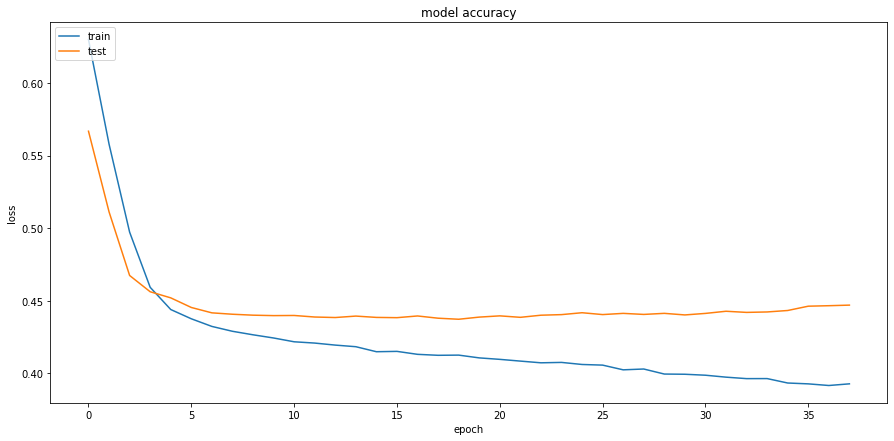

In [19]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
pred = model.predict(X_train)
pred[:5]

array([[0.12181836],
       [0.24092358],
       [0.09126234],
       [0.24617839],
       [0.05813554]], dtype=float32)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print("Test Score:", rf.score(X_test,y_test))
print("Train Score:", rf.score(X_train,y_train))

Test Score: 0.8206666666666667
Train Score: 0.9992631578947369


In [22]:
model.evaluate(X_train,y_train,batch_size=64)

446/446 [==============================] - 4s 10ms/step - loss: 0.4122 - accuracy: 0.8265 - auc: 0.8054 - prc: 0.5896


[0.4122195243835449,
 0.8264912366867065,
 0.8053687810897827,
 0.5896384716033936]

In [23]:
model.evaluate(X_test,y_test,batch_size=64)

24/24 [==============================] - 0s 9ms/step - loss: 0.4537 - accuracy: 0.8213 - auc: 0.7518 - prc: 0.5342


[0.45372289419174194,
 0.8213333487510681,
 0.751818060874939,
 0.5341559648513794]

Explainability : Lime

LIME ( Local Interpretable Model-agnostic Explanations )is a novel explanation technique that explains the prediction of any classifier in an interpretable and faithful manner by learning an interpretable model locally around the prediction.

In [25]:
from lime import lime_tabular
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
test_input = np.array(X_test.iloc[0:10,:])
test_input

array([[-0.02443046, -0.48299662, -0.04926386, ..., -0.00592359,
        -0.03021777, -0.08960391],
       [-0.02443046, -0.48299662, -0.04926386, ..., -0.00592359,
        -0.03021777, -0.08960391],
       [-0.02443046, -0.48299662, -0.04926386, ..., -0.00592359,
        -0.03021777, -0.08960391],
       ...,
       [-0.02443046, -0.48299662, -0.04926386, ..., -0.00592359,
        -0.03021777, -0.08960391],
       [-0.02443046, -0.48299662, -0.04926386, ..., -0.00592359,
        -0.03021777, -0.08960391],
       [-0.02443046, -0.48299662, -0.04926386, ..., -0.00592359,
        -0.03021777, -0.08960391]])

In [26]:
def predictKeras(testData_for_model):
    prediction_Class_1 = model.predict(testData_for_model) 
    x = np.zeros((prediction_Class_1.shape[0], 1))
    probability = (x + 1) - prediction_Class_1
    final = np.append(probability,prediction_Class_1, axis=1)
    return final

pb = predictKeras(X_test)

In [27]:
# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['No default','Default'], verbose=True, mode='classification')

In [28]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 2.277656911122504
Prediction_local [0.29277717]
Right: 0.06635582447052002


Intercept 1.9510665270315535
Prediction_local [0.26285436]
Right: 0.06635582447052002


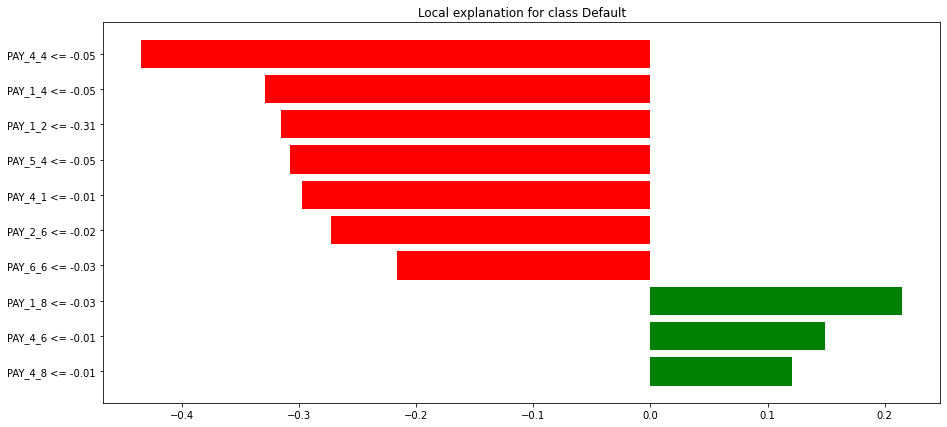

In [29]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

Intercept 2.5370053001388007
Prediction_local [0.2654164]
Right: 0.06635582447052002


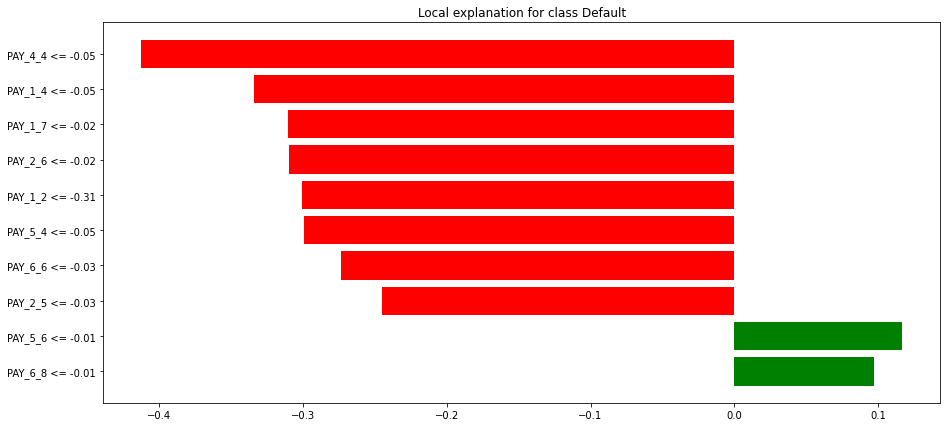

In [30]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

Intercept 2.192056013183364
Prediction_local [0.26504304]
Right: 0.06635582447052002


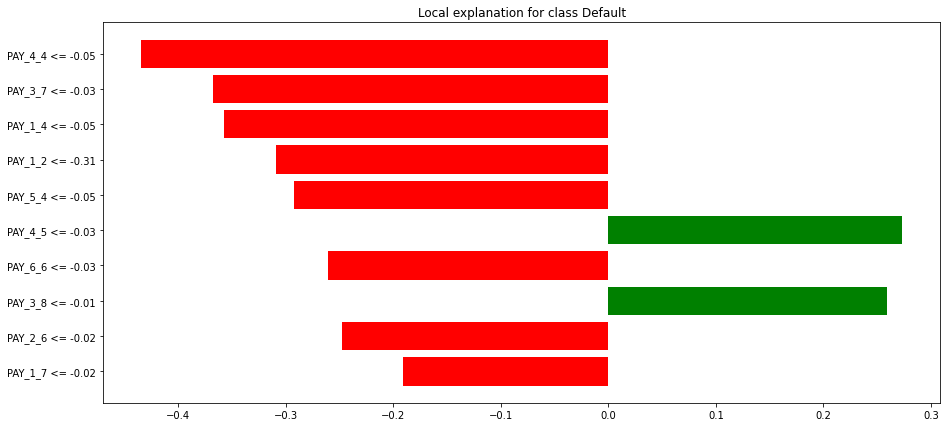

In [32]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

Intercept 2.771453732601439
Prediction_local [0.26338159]
Right: 0.06635582447052002


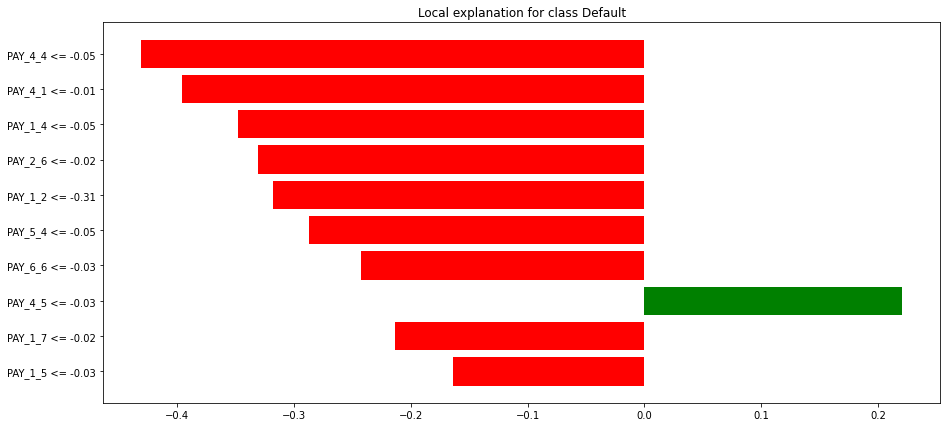

In [33]:
j = 0
exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=10)
#exp.show_in_notebook(show_table=True, show_all=False)
(exp.as_pyplot_figure());

As above, given it generates perturbation explanations are not very robust. There is higher consistency while generating lesser number of rules, say 3-4 but some randomness is seen when checking for multiple rules say 10-12.

In [34]:
X_test.shape[0]

1500

In [ ]:
X_exp = pd.DataFrame({'ID' : df_ID,'Var_1':None,'Var_2':None,'Var_3':None,'Var_4':None,'Var_5':None,
                      'Dir_1':None,'Dir_2':None,'Dir_3':None,'Dir_4':None,'Dir_5':None,
                      'Val_1':df_ID,'Val_2':df_ID,'Val_3':df_ID,'Val_4':df_ID,'Val_5':df_ID})
#print(X_exp)
import random
random.seed(10)
for j in range(len(X_test.iloc[0:X_test.shape[0]])):
    exp = explainer.explain_instance(X_test.values[j], predictKeras, num_features=5)
    #print(exp.as_list())
    lst1 = [y.split() for y in [x[0] for x in exp.as_list()]]

    lst2 = [item[0] for item in lst1]
    if(len(lst2)!=5):
        lst2+=(5-len(lst2))*['None']
    lst3 = [item[1] for item in lst1]
    if(len(lst3)!=5):
        lst3+=(5-len(lst3))*['None']
    lst4 = [item[2] for item in lst1]
    if(len(lst4)!=5):
        lst4+=(5-len(lst4))*['None']
    X_exp.iloc[j,1:len(X_exp.columns)] = lst2+lst3+lst4
    X_exp.to_csv('drive/MyDrive/Lime Interpretations Raw.csv')
X_exp


Intercept 0.7918420737529019
Prediction_local [0.28300792]
Right: 0.24409902095794678
Intercept 0.723650344785631
Prediction_local [0.15147358]
Right: 0.06980720162391663
Intercept 0.7609165527903259
Prediction_local [0.24636792]
Right: 0.1164332926273346
Intercept 0.8164207840269782
Prediction_local [0.15798499]
Right: 0.0629107654094696
Intercept 0.760858546157416
Prediction_local [0.20122822]
Right: 0.10831752419471741
Intercept 0.9042430127445891
Prediction_local [0.20863205]
Right: 0.07417768239974976
Intercept 0.45974887610004733
Prediction_local [0.20717946]
Right: 0.021592825651168823
Intercept 0.8123508022574066
Prediction_local [0.24263947]
Right: 0.17337548732757568
Intercept 0.7982407389614252
Prediction_local [0.20259748]
Right: 0.07039874792098999
Intercept 0.9112823060010002
Prediction_local [0.20824701]
Right: 0.150651752948761
Intercept 0.3353049060250684
Prediction_local [0.59473905]
Right: 0.6568994522094727
Intercept 0.7598599605297299
Prediction_local [0.24853675]


,ID,Var_1,Var_2,Var_3,Var_4,Var_5,Dir_1,Dir_2,Dir_3,Dir_4,Dir_5,Val_1,Val_2,Val_3,Val_4,Val_5
0,1,PAY_1_2,PAY_6_3,PAY_2_2,LIMIT_BAL,PAY_1_0,<=,<=,<=,<=,<=,-0.31,-0.08,-0.39,-0.91,-0.98
1,2,PAY_1_2,PAY_2_2,LIMIT_BAL,PAY_5_2,-0.98,<=,<=,>,<=,<,-0.31,-0.39,0.56,-0.31,PAY_1_0
2,3,PAY_1_2,ZERO_PAY_5,PAY_2_2,PAY_5_2,PAY_1_0,<=,<=,<=,<=,<=,-0.31,-0.19,-0.39,-0.31,-0.98
3,4,PAY_1_2,PAY_2_3,PAY_2_2,LIMIT_BAL,-0.98,<=,<=,<=,>,<,-0.31,-0.10,-0.39,0.56,PAY_1_0
4,5,PAY_1_2,PAY_2_3,PAY_2_2,LIMIT_BAL,PAY_1_0,<=,<=,<=,>,<=,-0.31,-0.10,-0.39,0.56,-0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,None,None,None,None,None,None,None,None,None,None,29996,29996,29996,29996,29996
29996,29997,None,None,None,None,None,None,None,None,None,None,29997,29997,29997,29997,29997
29997,29998,None,None,None,None,None,None,None,None,None,None,29998,29998,29998,29998,29998
29998,29999,None,None,None,None,None,None,None,None,None,None,29999,29999,29999,29999,29999


Explainability : Shap

In [36]:
print(tf.__version__)

2.7.0


In [37]:
# print the JS visualization code to the notebook
import shap
shap.initjs()

In [38]:
#Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 10))

In [41]:

# shap_values = explainer.shap_values(X_test)
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_test.iloc[1:100,:].values)
#max_display needed to show more than 20 features
shap.summary_plot(shap_values, X_new_train, max_display = len(X_new_train.columns))

  0%|          | 0/99 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
#pd.DataFrame(shap_values[0]).to_csv('drive/MyDrive/shap2.csv')
#Shap for 1500 datapoints
shap_v = pd.read_csv('drive/MyDrive/shap2.csv')


In [ ]:
shap_v = shap_v.iloc[:,1:(len(X_test.columns)+1)]

In [ ]:
(X_test.columns)

Index(['PAY_3_-1', 'PAY_3_0', 'PAY_1_0', 'ZERO_PAY_0', 'BILL_AMT2',
       'EDUCATION_0', 'ZERO_PAY_1', 'PAY_1_-2', 'ZERO_BAL_4', 'ZERO_PAY_3',
       ...
       'EDUCATION_1', 'PAY_1_4', 'PAY_5_2', 'ZERO_BAL_2', 'NEG_BAL_4',
       'PAY_4_4', 'PAY_1_-1', 'PAY_5_7', 'PAY_1_6', 'BILL_AMT1'],
      dtype='object', length=114)

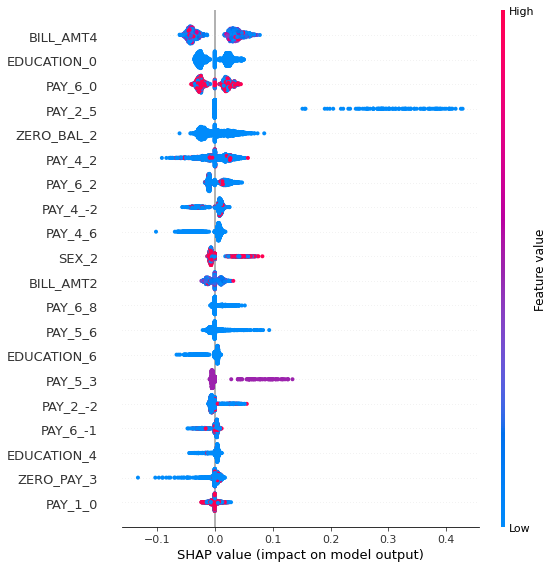

In [ ]:
shap.summary_plot(np.array(shap_v), X_test, max_display = 20)

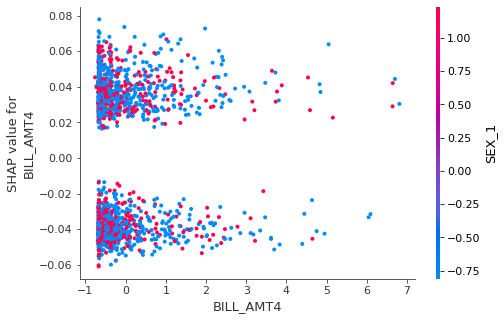

In [ ]:
# make plot
shap.dependence_plot('BILL_AMT4' , np.array(shap_v), (X_test) , interaction_index="SEX_1")

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_v.iloc[0,:]), X_test.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_v.iloc[0:15,:]), X_test.iloc[0:15,:])

In [43]:
from alibi.explainers import IntegratedGradients

#model = tf.keras.models.load_model("path_to_your_model")

ig  = IntegratedGradients(model,
                          layer=None,
                          method = "riemann_trapezoid",
                          n_steps=50,
                          internal_batch_size=100)

In [44]:
explanation = ig.explain(np.array(X_test),
                         baselines=None,
                         target=None)

attributions = explanation.attributions

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [45]:
len(attributions[0])

1500

In [46]:
np.mean(attributions[0],axis=1)

array([-0.00362348, -0.00387976, -0.0023038 , ..., -0.00392587,
        0.0029388 , -0.00369334])

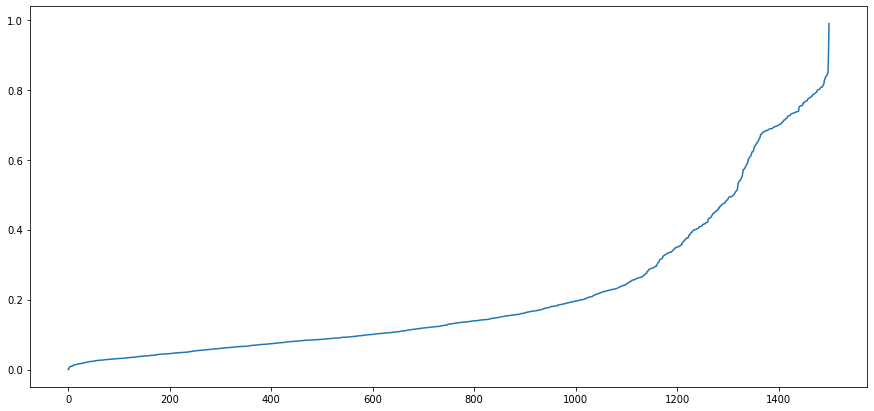

In [51]:
plt.plot(sorted(model.predict(X_test)))